##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [2]:
%pip install pandas 
%pip install matplotlib
%pip install scikit-learn
%pip install imblearn
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 


Note: you may need to restart the kernel to use updated packages.



## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [2]:
# Can have as many cells as you want for code
import pandas as pd
import os
os.getcwd()
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [27]:
###...code...###
# pd.show_versions()
df = pd.read_parquet(filepath)
df.head() # can only use 710 values to 
df['f_purchase_lh'] = df['f_purchase_lh'].fillna(0) # Since the purchase flag is either 1 or NaN, we can just change all the NaNs to 0
# corr_matrix = df.corr()["f_purchase_lh"] #returns the correlation matrix between each column and "f_purchase_lh"
# corr_matrix.sort_values(ascending=False).head(n=10)

At first glance, let's use the client risk indicators as our features.

In [18]:
# X = df[features]
# print(X.head())
# for f in features:
#     print(f)
#     print(df[df[f].isna()])

# from sklearn.model_selection import train_test_split
# train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
# from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=5)
# neigh.fit(train_X, train_y)

# create column blocks
cols_list = df.columns.tolist()

general_info = cols_list[:8]
risk_status = cols_list[8:18]
consent = cols_list[18:24]
demographics = cols_list[24:28] + cols_list[29:34]
history = cols_list[34:41] + [cols_list[28]] 
ape_categorised = cols_list[41:70]
sumins_categorised = cols_list[71:99]
prempaid_categorised = cols_list[100:129]
ape_total = cols_list[130:137] + [cols_list[70]]
f_hold_total = cols_list[137:144]
sumins_total = cols_list[144:151] + [cols_list[99]]
prempaid_total = cols_list[151:158] + [cols_list[129]]
lapse_ape_categorised = cols_list[158:183]
n_months_lapse = cols_list[183:208]
f_ever_bought_total = cols_list[208:215]
n_months_last_bought_total = cols_list[215:222]
f_ever_bought_categorised = cols_list[222:247]
n_months_last_bought_categorised = cols_list[247:272]
association = cols_list[272:275]
affcon = cols_list[275:280]
clmcon = cols_list[280:283]
claim_metrics = cols_list[283:289] + cols_list[293:299]
specific_policy_flag_metric = cols_list[289:293] + cols_list[299:-1]

duplicated_ape = ["ape_lh_839f8a", "ape_lh_e22a6a", "ape_lh_d0adeb", "ape_lh_507c37"]
duplicated_sumins = ["sumins_lh_e22a6a", "sumins_lh_d0adeb", "sumins_lh_507c37"]
duplicated_prempaid = ['prempaid_lh_839f8a', 'prempaid_lh_e22a6a', 'prempaid_lh_d0adeb', 'prempaid_lh_507c37']
distinct_ape = list(set(ape_categorised) - set(duplicated_ape)) + ape_total
distinct_sumins = list(set(sumins_categorised) - set(duplicated_sumins)) + sumins_total
distinct_prempaid = list(set(prempaid_categorised) - set(duplicated_prempaid)) + prempaid_total


Now we have a problem.  Our flag indicators have three possible values: 1, 0 and NaN.
Thankfully, after evaluation we see that all the ones with NaN in the flag variables are the same, so should we throw them away?

On the other hand, shall we interpolate it? or use KNN imputation?

Nevermind, are there any entries where no flag variables are keyed in, but they bought the policy?

In [8]:
# Since they're all NaN, let's just pick one column where it's NaN and then condense from there

# df[(df['flg_substandard'].isna()) & (df['f_purchase_lh'] != 0)] # 10 rows where the flag is gone but they purchased, out of 17992
# 1004 rows have NaN in flag, but didn't purchase
# 1014 total NaN in flag
# just remove
new_df = df[df['flg_substandard'].notna()]

C:\Users\user\AppData\Local\Temp\ipykernel_15628\3416611962.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['ape_sum'] = new_df[distinct_ape].sum()


KeyError: 'f_purchased_lh'

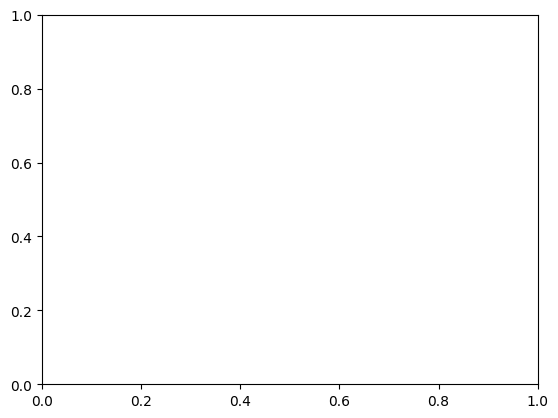

In [28]:
features = distinct_ape + distinct_sumins + distinct_prempaid + claim_metrics + risk_status
newdf_X = new_df[features]
newdf_y = new_df['f_purchase_lh']
new_df['ape_sum'] = new_df[distinct_ape].sum()
new_df.plot(kind='scatter', x='ape_sum', y='f_purchased_lh')

Just how many policies are there in our dataset? Lord

'ape_839f8a',
 'ape_e22a6a',
 'ape_d0adeb',
 'ape_c4bda5',
 'ape_ltc',
 'ape_507c37',
 'ape_gi',

The brackets behind the policy code will have three numbers, `ape_`, `sumins_` and `prempaid_`.
1. 42e115 (1, 1, 1) - GI
2. 1280bf (2, 2, 2) - LTC
3. 6fc3e6 (3, 3, 3) - GRP
4. de05ae (4, 4, 4) - GRP
5. dcd836 (5, 5, 5) - INV
6. 945b5a (6, 6, 6) - GRP
7. 6a5788 (7, 7, 7) - GRP
8. 43b9d5 (8, 8, 8) - LTC
9. 9cdedf (9, 9, 9) - GRP
10. d0adeb (10, 10, 10) - LH, Total (after sumins, after e22a6a)
11. 1581d7 (11, 11, 11) - GRP
12. 22decf (12, 12, 12) - GRP
13. 507c37 (13, 13, 13) - LH, Total (after sumins of LTC)
14. 839f8a (14, x, 14) - LH, Total (after sumins)
15. e9f316 (15, 14, 15) - INV
16. a10d1b (16, 15, 16) - GI
17. 29d435 (17, 16, 17) - GI
18. caa6ff (18, 17, 18) - GRP
19. fd3bfb (19, 18, 19) - GRP
20. e22a6a (20, 19, 20) - LH, Total (after sumins, after 839f8a)
21. 70e1dd (21, 20, 21) - GRP
22. e04c3a (22, 21, 22) - GRP
23. fe5fb8 (23, 22, 23) - GRP
24. 856320 (24, 23, 24) - GI
25. 94baec (25, 24, 25) - GRP
26. 058815 (26, 25, 26) - GI
27. e91421 (27, 26, 27) - GRP
28. f852af (28, 27, 28) - LH
29. 947b15 (29, 28, 29) - LH
30. 32c74c (30, 29, 30) - N/A (must be total)
31. c4bda5 - N/A (total after d0adeb)

839f8a got two APE hmm

The duplicated APE's are "839f8a", "e22a6a", "d0adeb", "507c37" 

In [27]:
cols = df.columns
my_df = [col for col in cols if '839f8a' in col]
my_df

# with_lh = df['ape_lh_839f8a']
# no_lh = df[ 'ape_839f8a']
# both = df[['ape_lh_839f8a', 'ape_839f8a']]
# print(both.sort_values(['ape_lh_839f8a'], ascending=False).head(n=20))
# # with_lh.sort_values('ape_839f8a')
# # with_lh


['ape_lh_839f8a',
 'prempaid_lh_839f8a',
 'ape_839f8a',
 'f_hold_839f8a',
 'sumins_839f8a',
 'prempaid_839f8a',
 'lapse_ape_lh_839f8a',
 'n_months_since_lapse_lh_839f8a',
 'f_ever_bought_839f8a',
 'n_months_last_bought_839f8a',
 'f_ever_bought_lh_839f8a',
 'n_months_last_bought_lh_839f8a',
 'flg_hlthclaim_839f8a_ever',
 'recency_hlthclaim_839f8a']

The policy 839f8a has two columns for Annual Premium Equivalent, where the values are distinct.  What would this mean?

In [27]:
# ok I am just going to drop all the ones where the flags are NaN.

filtered_flag_df = df[~df['flg_substandard'].isna()]
filtered_flag_df

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,3363260248,None,Singapore,P,LAPSED,2016-08-01,1994-05-24,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
11964,c3509f0aef,Chinese,Singapore,P,ACTIVE,1990-03-20,1948-12-16,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
5390,6e44cfb3e7,Chinese,Singapore,P,ACTIVE,2007-12-31,1967-12-06,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
860,dd4e362f9f,Others,Singapore,P,ACTIVE,2007-09-01,1986-04-01,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0


So, investigating the correlation matrix, we find that the columns that are correlated to `f_purchase_lh` are as follows:
1. `f_ever_bought_gi`, has the customer ever bought general insurance?
2. `flg_gi_claim`, a flag value to determine whether the customer has claimed a general insurance policy.


I am using this block to find all columns with 'ape_' in it.

In [27]:
ape_cols = [data for data in df if 'ape' in data]
ape_cols
df[['flg_substandard', 'f_purchase_lh']]


,flg_substandard,f_purchase_lh
19550,0.0,NaN
4600,0.0,NaN
13337,0.0,NaN
15074,0.0,NaN
19724,0.0,NaN
...,...,...
11284,0.0,NaN
11964,0.0,NaN
5390,0.0,NaN
860,0.0,NaN


clttype = P, C, G?
We hypothesise that P means personal, C is company, G is general!!!

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [14]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!